In [1]:
from explainers.gnninterpreter import * 


In [2]:
import torch
from torch import nn

import libraries.dataLoaderWrapper 

In [3]:
dataset = torch.load('model/gnni_test_loader_red_ratio.pt')

In [4]:
import numpy as np
y = [data.y for data in dataset]
classes = np.unique(y)

model = GCNClassifier(node_features=len(dataset[0].x[0]),
                      num_classes=len(classes),
                      hidden_channels=32)

model.load_state_dict(torch.load('model/gnni_model_red_class.pt'))

<All keys matched successfully>

In [5]:
mean_embeds = dataset.mean_embeddings(model)

In [6]:
dataset.NODE_CLS

{0: [1.0, 0.0, 0.0], 1: [0.0, 1.0, 0.0], 2: [0.0, 0.0, 1.0]}

In [7]:
trainer = {}
sampler ={}

In [8]:
cls_idx = 0
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=40,
        num_node_cls=3,
        temperature=0.15,
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=10),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
    target_probs={cls_idx: (0.9, 1)},
    k_samples=16
)

In [9]:
trainer[0].train(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

In [10]:
dataset.NODE_CLS


{0: [1.0, 0.0, 0.0], 1: [0.0, 1.0, 0.0], 2: [0.0, 0.0, 1.0]}

n=11 m=6
logits=[6.3669843673706055, 0.20176753401756287, -3.738229990005493]
probs=[0.9978623986244202, 0.0020967707969248295, 4.0778562834020704e-05]


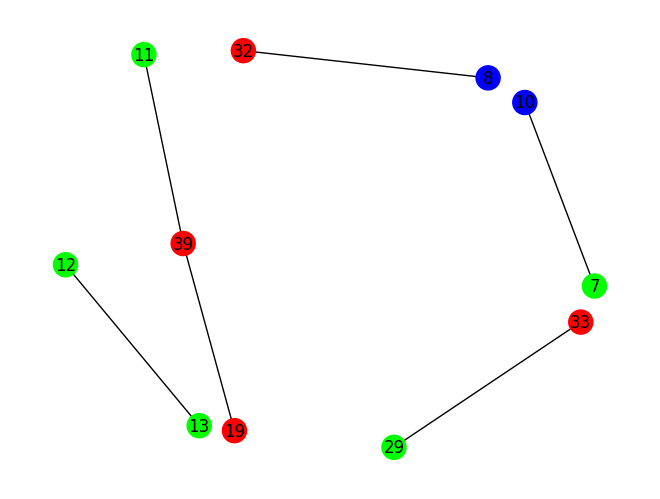

In [11]:
graph = trainer[0].evaluate(threshold=0.1, show=True)
# labels = [dataset.NODE_CLS[graph.nodes[node]['label']] for node in graph.nodes]
# import networkx as nx
# nx.draw(graph, nx.kamada_kawai_layout(graph), node_color=labels)